Para empezar la limpieza de datos empezaros primero cargando librerias e ir limpiando columna a columna las cosas que no nos cuadren.

In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(22)

Queremos limpiar nulls y datos que no concuerdan

In [258]:
df = pd.read_csv("../data/raw/bgg_dataset.csv",sep=";")

In [259]:
df["Complexity Average"] = df["Complexity Average"].str.replace(",",".").astype(float) # Cambiamos las comas por puntos y pasamos a float
df["Rating Average"] = df["Rating Average"].str.replace(",",".").astype(float) # Cambiamos las comas por puntos y pasamos a float
media_valores_año = int(np.mean(df.loc[df["Year Published"] >= 0, "Year Published"])) # Hacemos la media de los años para dar un valor concreto a los años
df.loc[df["Year Published"] < 1, "Year Published"] = media_valores_año # Miramos que todos los años menores de 1 sean
df.loc[df["Year Published"].isna(), "Year Published"] = media_valores_año
df["Year Published"] = df["Year Published"].astype(int) # Pasamos a int todos los años


Quitamos de la fila de Domains los null como no definidos.

In [260]:
df.loc[df["Domains"].isnull(), "Domains"] = "Not Defined" # Definimos como "Not Defined" los valores null del dataset

En Mechanics ponemos los nulls igual que en domains como "Not Defined"

In [261]:
df.loc[df["Mechanics"].isnull(), "Mechanics"] = "Not Defined" # Definimos como "Not Defined" los valores null del dataset

En Owned Users ponemos los nulls igual que en domains como "Not Defined"

In [262]:
media_valores_owned = int(np.mean(df.loc[df["Owned Users"] >= 0, "Owned Users"]))
df.loc[df["Owned Users"].isna(), "Owned Users"] = media_valores_owned # Definimos los valores null como media de owned por juego.
df["Owned Users"] = df["Owned Users"].astype(int)

In [263]:
df["Rating Average"]

0        8.79
1        8.61
2        8.66
3        8.43
4        8.70
         ... 
20338    2.28
20339    2.85
20340    3.18
20341    2.86
20342    2.68
Name: Rating Average, Length: 20343, dtype: float64

En ID tendremos que asignar valores que no estén repetidos en las columnas. Quitamos los valores nulos y sustituimos por valores aleatorios.


In [264]:
valores_nulos = df["ID"].isnull() # Vemos los valores nulos
valores_no_nulos = df["ID"].dropna().unique() # Sacamos los valores que no son nulos
valores_aleatorios = np.random.choice(valores_no_nulos, size=valores_nulos.sum(), replace=False) # Hacemos valores aleatorios en una variable
df.loc[valores_nulos, "ID"] = valores_aleatorios # Cambiamos valores nulos y sustituimos por valores aleatorios 
df["ID"] = df["ID"].astype(int)

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20343 non-null  int32  
 1   Name                20343 non-null  object 
 2   Year Published      20343 non-null  int32  
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  float64
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  float64
 11  Owned Users         20343 non-null  int32  
 12  Mechanics           20343 non-null  object 
 13  Domains             20343 non-null  object 
dtypes: float64(2), int32(3), int64(6), object(3)
memory usage: 1.9+ MB


Ahora toca limpiar las columnas mechanics y domains, quizas las que más trabajo llevan. Primero empezaré con Domains

In [266]:
df = df.join(df['Domains'].str.split(expand=True))
df = pd.get_dummies(df, columns=[0,1,2,3,4,5])


Ahora vamos asociando cada columna creada con el get dummies y poniendo nombre a cada tipo de juego dejandolo todo en 0 y 1 

In [267]:
df["Children"] = df[["0_Children's", "2_Children's"]].any(axis='columns').astype(int)
df["Customizable"] = df[["2_Customizable", "0_Customizable"]].any(axis='columns').astype(int)
df["Family"] = df[["2_Family", "0_Family"]].any(axis='columns').astype(int)
df["Party"] = df[["0_Party", "2_Party","4_Party"]].any(axis='columns').astype(int)
df["Strategy"] = df[["0_Strategy", "2_Strategy"]].any(axis='columns').astype(int)
df["Thematic"] = df[["0_Thematic", "2_Thematic","4_Thematic"]].any(axis='columns').astype(int)
df["Wargames"] = df[["0_Wargames", "2_Wargames","4_Wargames"]].any(axis='columns').astype(int)
df["Domain_Not Defined"] = df[["0_Not","1_Defined"]].any(axis='columns').astype(int)
df = df.rename(columns={"0_Abstract":"Abstract"})
df["Abstract"].astype(int)
df.drop(["0_Children's", '0_Customizable', '0_Family', '0_Not',
       '0_Party', '0_Strategy', '0_Thematic', '0_Wargames', '1_Defined',
       '1_Games', '1_Games,', "2_Children's", '2_Customizable', '2_Family',
       '2_Party', '2_Strategy', '2_Thematic', '2_Wargames', '3_Games',
       '3_Games,', '4_Party', '4_Thematic', '4_Wargames', '5_Games'],inplace=True,axis=1)

Ahora toca hacer algo parecido con la columna Mechanics, al haber bastante más tipos de registros de mecanicas de juego.  
Primero separaremos por las comas la columna de Mechanics

In [268]:
df_descriptions = df['Mechanics'].str.get_dummies(', ')

df = pd.concat([df, df_descriptions], axis=1)

In [269]:
df.columns

Index(['ID', 'Name', 'Year Published', 'Min Players', 'Max Players',
       'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank',
       ...
       'Turn Order: Role Order', 'Turn Order: Stat-Based',
       'Variable Phase Order', 'Variable Player Powers', 'Variable Set-up',
       'Victory Points as a Resource', 'Voting', 'Worker Placement',
       'Worker Placement with Dice Workers', 'Zone of Control'],
      dtype='object', length=206)

Ahora toca procesar informacion y unir muchas mecanicas de juegos para dejarlo lo mas generalizado posible.

In [270]:
df["Mech_Acting"] = df[["Communication Limits","Alliances","Acting","Player Judge","Role Playing","Roles with Asymmetric Information","Storytelling", "Traitor Game","Catch the Leader","Follow","Force Commitment","Hidden Roles","Negotiation","Voting"]].any(axis='columns').astype(int)
df["Mech_Action"] = df[["Static Capture","Sudden Death Ending","Simultaneous Action Selection","Matching","Cube Tower","Bias","Real-Time","Push Your Luck","Action Drafting", "Action Points","Action Queue","Action Retrieval","Action Timer","Action/Event","Critical Hits and Failures","Hot Potato","I Cut You Choose","Interrupts","Kill Steal","Ladder Climbing","Line Drawing","Paper-and-Pencil","Race","Singing","Take That","Three Dimensional Movement","Track Movement","Measurement Movement"]].any(axis='columns').astype(int)
df["Mech_tokens"] = df[["Physical Removal","Advantage Token", "Passed Action Token"]].any(axis='columns').astype(int)
df["Mech_construcc_farm"] = df[["Tech Trees / Tech Tracks","Resource to Move","Automatic Resource Growth","Random Production","Mancala","Network and Route Building","Ownership","Pattern Building","Pick-up and Deliver"]].any(axis='columns').astype(int)
df["Mech_roll_thng"] = df[["Variable Set-up","Worker Placement with Dice Workers","Roll / Spin and Move","Flicking","Re-rolling and Locking","Rondel","Dice Rolling","Different Dice Movement"]].any(axis='columns').astype(int)
df["Mech_cards"] = df[["Trick-taking","Melding and Splaying","Drafting","Set Collection","Move Through Deck","Hand Management","Deck Construction","Deck Bag and Pool Building","Campaign / Battle Card Driven","Card Drafting","Card Play Conflict Resolution","Chaining","Command Cards"]].any(axis='columns').astype(int)
df["Mech_role_camp"] = df[["Variable Player Powers","Worker Placement","Stat Check Resolution","Simulation","Scenario / Mission / Campaign Game","Ratio / Combat Results Table","Narrative Choice / Paragraph","Multiple Maps","Legacy Game","Finale Ending","Events","End Game Bonuses","Enclosure","Elapsed Real Time Ending","Different Worker Types","Die Icon Resolution"]].any(axis='columns').astype(int)
df["Mech_board"] = df[["Tile Placement","Square Grid","Slide/Push","Line of Sight","Zone of Control","Secret Unit Deployment","Point to Point Movement","Pieces as Map","Moving Multiple Units","Movement Template","Movement Points","Modular Board","Minimap Resolution","Map Reduction","Map Deformation","Map Addition","Layering","Impulse Movement","Hidden Movement","Hexagon Grid","Grid Movement","Grid Coverage","Crayon Rail System","Connections","Area Movement","Area Majority / Influence","Area-Impulse"]].any(axis='columns').astype(int)
df["Mech_money"] = df[["Trading","Stock Holding","Stacking and Balancing","Selection Order Bid","Predictive Bid","Order Counters","Multiple-Lot Auction","Market","Loans","Investment","Increase Value of Unchosen Resources","Income","Delayed Purchase","Contracts","Closed Economy Auction","Constrained Bidding","Commodity Speculation","Bribery","Bingo","Betting and Bluffing","Auction/Bidding","Auction: Dexterity","Auction: Dutch","Auction: Dutch Priority","Auction: English","Auction: Fixed Placement","Auction: Once Around","Auction: Sealed Bid","Auction: Turn Order Until Pass"]].any(axis='columns').astype(int)
df["Mech_score"] = df[["Victory Points as a Resource","Player Elimination","Highest-Lowest Scoring","Hidden Victory Points","Score-and-Reset Game"]].any(axis='columns').astype(int)
df["Mech_turnbased"] = df[["Variable Phase Order","Turn Order: Stat-Based","Turn Order: Role Order","Turn Order: Random","Turn Order: Progressive","Turn Order: Pass Order","Turn Order: Claim Action","Turn Order: Auction","Relative Movement","Programmed Movement","Pattern Recognition","Pattern Movement","Lose a Turn","Chit-Pull System"]].any(axis='columns').astype(int)
df["Mech_team"] = df[["Tug of War","Prisoner's Dilemma","Team-Based Game","Semi-Cooperative Game","Cooperative Game"]].any(axis='columns').astype(int)
df["Mech_skill"] = df[["Time Track","Targeted Clues","Induction","Deduction","Speed Matching","Rock-Paper-Scissors","Once-Per-Game Abilities","Memory"]].any(axis='columns').astype(int)
df["Mech_solo"] = df[["King of the Hill","Single Loser Game","Solo / Solitaire Game"]].any(axis='columns').astype(int)
df = df.rename(columns={"Not Defined":"Mech Not Defined"})
df.drop(["King of the Hill","Communication Limits","Alliances","Acting","Player Judge","Role Playing","Roles with Asymmetric Information","Storytelling", "Traitor Game","Catch the Leader","Follow","Force Commitment","Hidden Roles","Negotiation","Voting","Static Capture","Sudden Death Ending","Simultaneous Action Selection","Matching","Cube Tower","Bias","Real-Time","Push Your Luck","Action Drafting", "Action Points","Action Queue","Action Retrieval","Action Timer","Action/Event","Critical Hits and Failures","Hot Potato","I Cut You Choose","Interrupts","Kill Steal","Ladder Climbing","Line Drawing","Paper-and-Pencil","Race","Singing","Take That","Three Dimensional Movement","Track Movement","Measurement Movement","Physical Removal","Advantage Token", "Passed Action Token","Tech Trees / Tech Tracks","Resource to Move","Automatic Resource Growth","Random Production","Mancala","Network and Route Building","Ownership","Pattern Building","Pick-up and Deliver","Variable Set-up","Worker Placement with Dice Workers","Roll / Spin and Move","Flicking","Re-rolling and Locking","Rondel","Dice Rolling","Different Dice Movement","Trick-taking","Melding and Splaying","Drafting","Set Collection","Move Through Deck","Hand Management","Deck Construction","Deck Bag and Pool Building","Campaign / Battle Card Driven","Card Drafting","Card Play Conflict Resolution","Chaining","Command Cards","Variable Player Powers","Worker Placement","Stat Check Resolution","Simulation","Scenario / Mission / Campaign Game","Ratio / Combat Results Table","Narrative Choice / Paragraph","Multiple Maps","Legacy Game","Finale Ending","Events","End Game Bonuses","Enclosure","Elapsed Real Time Ending","Different Worker Types","Die Icon Resolution","Tile Placement","Square Grid","Slide/Push","Line of Sight","Zone of Control","Secret Unit Deployment","Point to Point Movement","Pieces as Map","Moving Multiple Units","Movement Template","Movement Points","Modular Board","Minimap Resolution","Map Reduction","Map Deformation","Map Addition","Layering","Impulse Movement","Hidden Movement","Hexagon Grid","Grid Movement","Grid Coverage","Crayon Rail System","Connections","Area Movement","Area Majority / Influence","Area-Impulse","Trading","Stock Holding","Stacking and Balancing","Selection Order Bid","Predictive Bid","Order Counters","Multiple-Lot Auction","Market","Loans","Investment","Increase Value of Unchosen Resources","Income","Delayed Purchase","Contracts","Closed Economy Auction","Constrained Bidding","Commodity Speculation","Bribery","Bingo","Betting and Bluffing","Auction/Bidding","Auction: Dexterity","Auction: Dutch","Auction: Dutch Priority","Auction: English","Auction: Fixed Placement","Auction: Once Around","Auction: Sealed Bid","Auction: Turn Order Until Pass","Victory Points as a Resource","Player Elimination","Highest-Lowest Scoring","Hidden Victory Points","Score-and-Reset Game","Variable Phase Order","Turn Order: Stat-Based","Turn Order: Role Order","Turn Order: Random","Turn Order: Progressive","Turn Order: Pass Order","Turn Order: Claim Action","Turn Order: Auction","Relative Movement","Programmed Movement","Pattern Recognition","Pattern Movement","Lose a Turn","Chit-Pull System","Tug of War","Prisoner's Dilemma","Team-Based Game","Semi-Cooperative Game","Cooperative Game","Time Track","Targeted Clues","Induction","Deduction","Speed Matching","Rock-Paper-Scissors","Once-Per-Game Abilities","Memory","Single Loser Game","Solo / Solitaire Game"],inplace=True,axis=1)

In [271]:
df.columns

Index(['ID', 'Name', 'Year Published', 'Min Players', 'Max Players',
       'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank',
       'Complexity Average', 'Owned Users', 'Mechanics', 'Domains', 'Abstract',
       'Children', 'Customizable', 'Family', 'Party', 'Strategy', 'Thematic',
       'Wargames', 'Domain_Not Defined', 'Mech Not Defined', 'Mech_Acting',
       'Mech_Action', 'Mech_tokens', 'Mech_construcc_farm', 'Mech_roll_thng',
       'Mech_cards', 'Mech_role_camp', 'Mech_board', 'Mech_money',
       'Mech_score', 'Mech_turnbased', 'Mech_team', 'Mech_skill', 'Mech_solo'],
      dtype='object')

Una vez ya tenemos todos los features ordenados, sin valores nulos y lo mejor clasificado posible vamos a hacer el [analisis de datos](www.linkagithub.com) y el [modelo de predicción](www.linkagithub.com)

In [132]:
for i in df["Mechanics"]:
    print(i)

Action Queue, Action Retrieval, Campaign / Battle Card Driven, Card Play Conflict Resolution, Communication Limits, Cooperative Game, Deck Construction, Deck Bag and Pool Building, Grid Movement, Hand Management, Hexagon Grid, Legacy Game, Modular Board, Once-Per-Game Abilities, Scenario / Mission / Campaign Game, Simultaneous Action Selection, Solo / Solitaire Game, Storytelling, Variable Player Powers
Action Points, Cooperative Game, Hand Management, Legacy Game, Point to Point Movement, Set Collection, Trading, Variable Player Powers
Hand Management, Income, Loans, Market, Network and Route Building, Score-and-Reset Game, Tech Trees / Tech Tracks, Turn Order: Stat-Based, Variable Set-up
Card Drafting, Drafting, End Game Bonuses, Hand Management, Hexagon Grid, Income, Set Collection, Solo / Solitaire Game, Take That, Tile Placement, Turn Order: Progressive, Variable Player Powers
Action Drafting, Area Majority / Influence, Area-Impulse, Dice Rolling, Follow, Grid Movement, Hexagon Gr

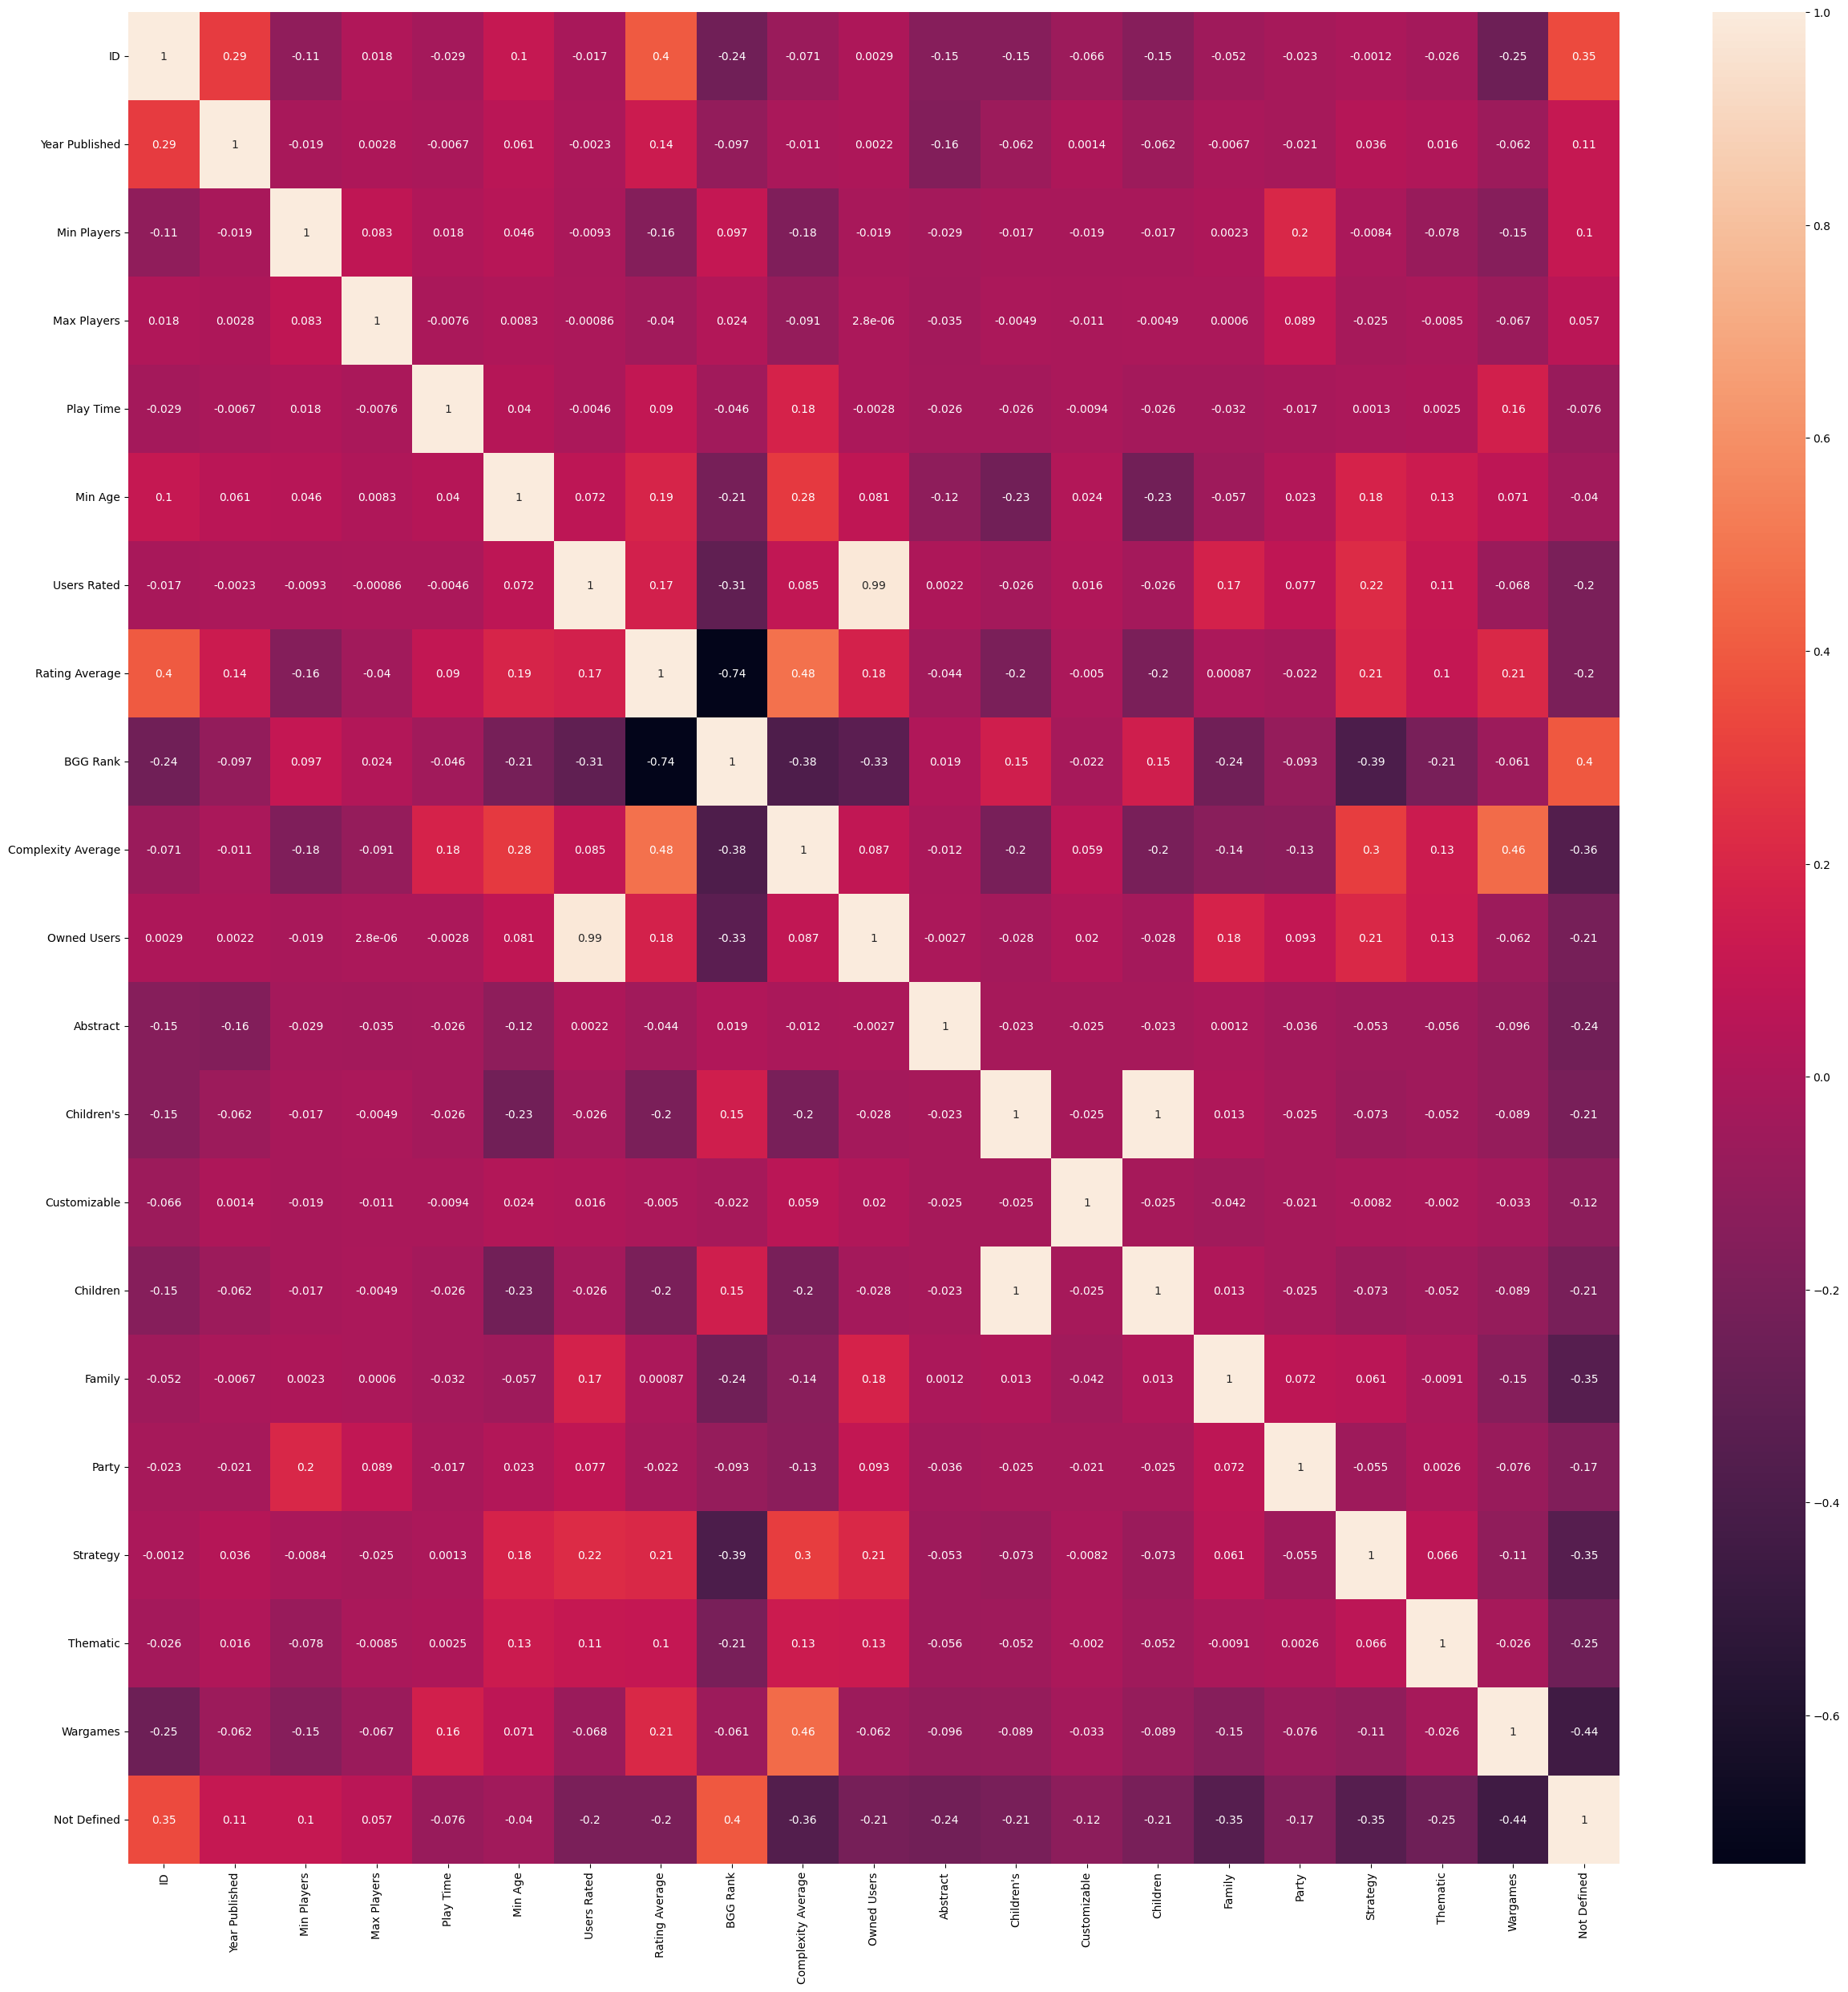

In [97]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), annot=True);